In [2]:
%matplotlib inline

import functions as fun
from collections import Counter
import ast
import pickle
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence
from matplotlib import pyplot
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15,10)
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy.sparse import csr_matrix

import pydot
import os
import numpy as np
import scipy as sp
import datetime
import matplotlib.pyplot as plt
from scipy.integrate import odeint 
import pandas as pd
import scipy as sp 
import string
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence

from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow_hub as hub
import tensorflow as tf
import tensorboard as ts
print("Number of GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using TensorFlow backend.


Number of GPUs:  1


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
print(tf.__version__)

2.1.0


In [5]:
df_snip = pd.read_pickle("./df_snip.pkl")
df_snip.reset_index(drop=False, inplace=True)
df_snip.set_index('claimID')
df_snip.head(2)

,claimID,snip_id,snip_1,snip_2,snip_url
0,abbc-00002,2,Full text: Senator Fraser Anning's maiden spee...,"Aug 15, 2018 ... Katter's Australia Party sena...",sbs.com.au
1,abbc-00002,3,Fraser Anning speech: Senator talks of final s...,"Aug 15, 2018 ... Queensland Senator Fraser Ann...",9news.com.au


In [16]:
df_train = pd.read_pickle("./df_train.pkl")
df_train.reset_index(drop=False, inplace=True)
df_train['domain'] = df_train.apply(lambda x: x.claimID.split('-')[0] , axis = 1 )
df_train.head(2)
#df_train[df_train['claimID'] =='tron-00214']

,claimID,index,claim,claimURL,reason,categories,speaker,checker,tags,articleTitle,publishDate,claimDate,entities,domain
0,pomt-03627,0,Six out of 10 of the highest unemployment rate...,/ohio/statements/2013/may/06/chris-redfern/ohi...,When a couple of Statehouse Republicans prepar...,NaN,Chris Redfern,NaN,NaN,NaN,2013-05-06T06:00:00,2013-04-30,NaN,pomt
1,pomt-09611,1,No Democratic campaign for (Fla.) governor has...,/florida/statements/2010/jan/15/alex-sink/flor...,Florida's leading Republican candidate for gov...,NaN,Alex Sink,NaN,NaN,NaN,2010-01-15T13:59:00,2010-01-06,NaN,pomt


In [11]:
test_set = df_snip.merge(df_train, left_on='claimID', right_on='claimID')
test_set.head(2)

,claimID,snip_id,snip_1,snip_2,snip_url,claim,label,claimURL,reason,categories,speaker,checker,tags,articleTitle,publishDate,claimDate,entities,domain
0,abbc-00002,2,Full text: Senator Fraser Anning's maiden spee...,"Aug 15, 2018 ... Katter's Australia Party sena...",sbs.com.au,"In his first speech to Parliament, Senator Fra...",in-the-red,http://www.abc.net.au/news/2018-08-24/fact-che...,"The majority of working-age Muslims, that is m...","['minor-parties', 'islam', 'work', 'immigratio...",None,None,"['minor-parties', 'islam', 'work', 'immigratio...",Fact check: Are a majority of working-age Aust...,"Thu 6 Sep 2018, 7:11am",None,"['Australia', 'Australian_Party']",abbc
1,abbc-00002,3,Fraser Anning speech: Senator talks of final s...,"Aug 15, 2018 ... Queensland Senator Fraser Ann...",9news.com.au,"In his first speech to Parliament, Senator Fra...",in-the-red,http://www.abc.net.au/news/2018-08-24/fact-che...,"The majority of working-age Muslims, that is m...","['minor-parties', 'islam', 'work', 'immigratio...",None,None,"['minor-parties', 'islam', 'work', 'immigratio...",Fact check: Are a majority of working-age Aust...,"Thu 6 Sep 2018, 7:11am",None,"['Australia', 'Australian_Party']",abbc


# Lables wordcloud

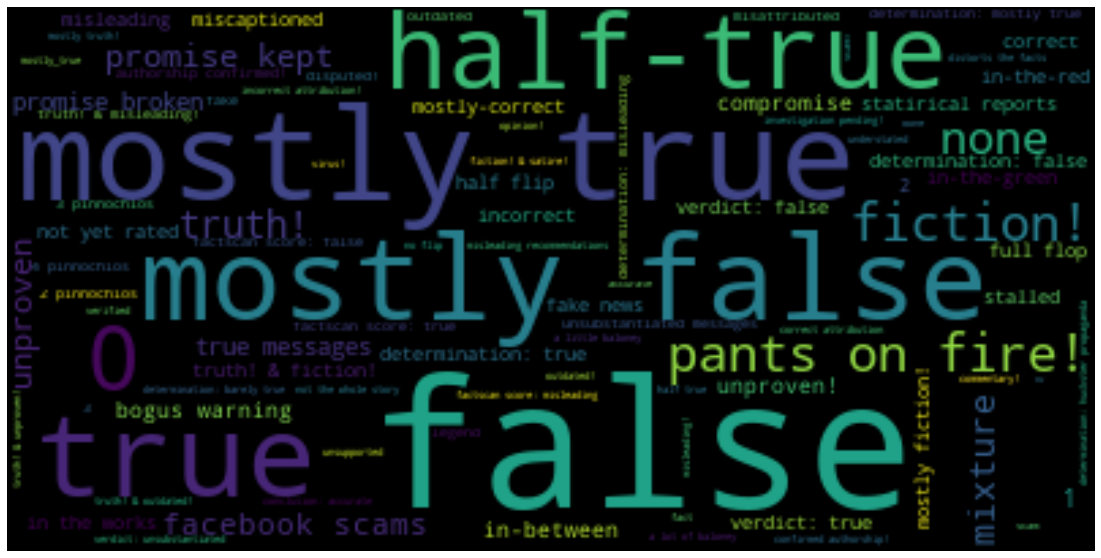

In [5]:
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=df_train.groupby(['label']).size().to_dict())
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Domain size

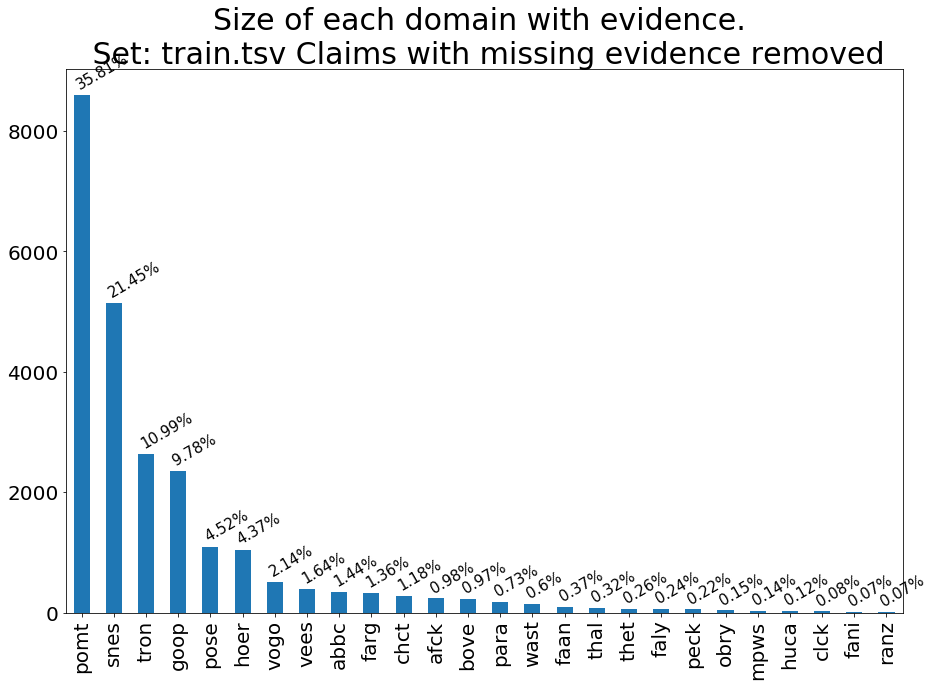

In [18]:
# The code for displaying % in barplot : https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html


axes = df_train['domain'].value_counts().plot(kind='bar',fontsize=20, )
axes.set_title('Size of each domain with evidence. \n Set: train.tsv Claims with missing evidence removed', fontsize=30)

totals = []

for i in axes.patches:
    totals.append(i.get_height())

total = sum(totals)

for i in axes.patches:
    axes.text(i.get_x(), i.get_height() + 100, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,rotation=30)



label
correct attribution      17
false                  2899
legend                   51
misattributed            28
miscaptioned            122
mixture                 555
mostly false            340
mostly true             128
outdated                 40
scam                     25
true                    585
unproven                364
dtype: int64

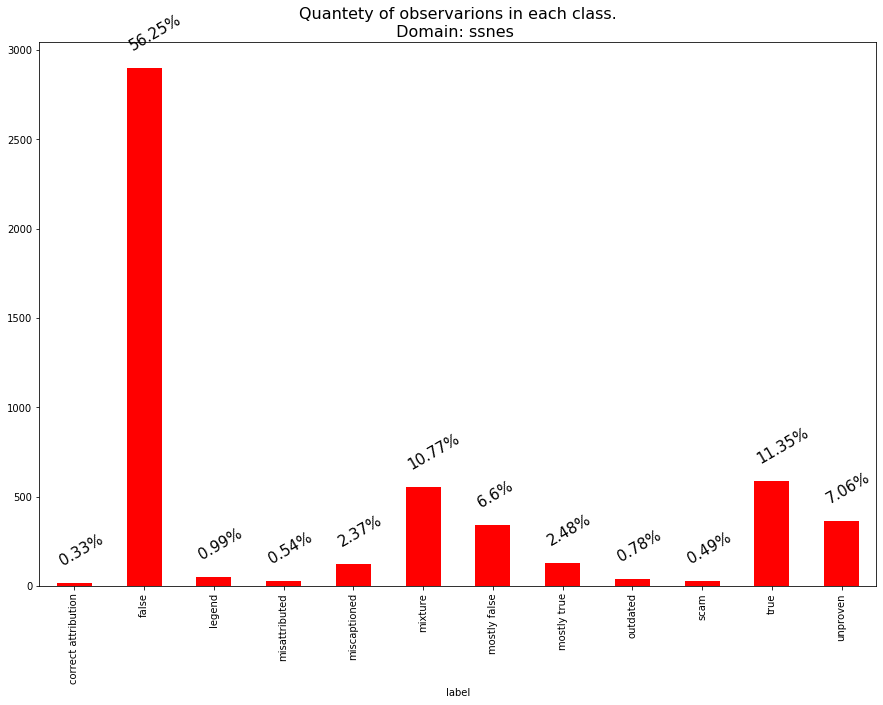

In [14]:
# The code for displaying % in barplot : https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html

#pompt
axes = df_train[ df_train['domain'].isin(['snes'])  ].groupby(['label']).size().plot(kind='bar',color='r')
axes.set_title('Quantety of observarions in each class.\n Domain: ssnes  ', fontsize=16)

totals = []

for i in axes.patches:
    totals.append(i.get_height())

total = sum(totals)

for i in axes.patches:
    axes.text(i.get_x(), i.get_height() + 100, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,rotation=30)

df_train[ df_train['domain'].isin(['snes'])  ].groupby(['label']).size() 

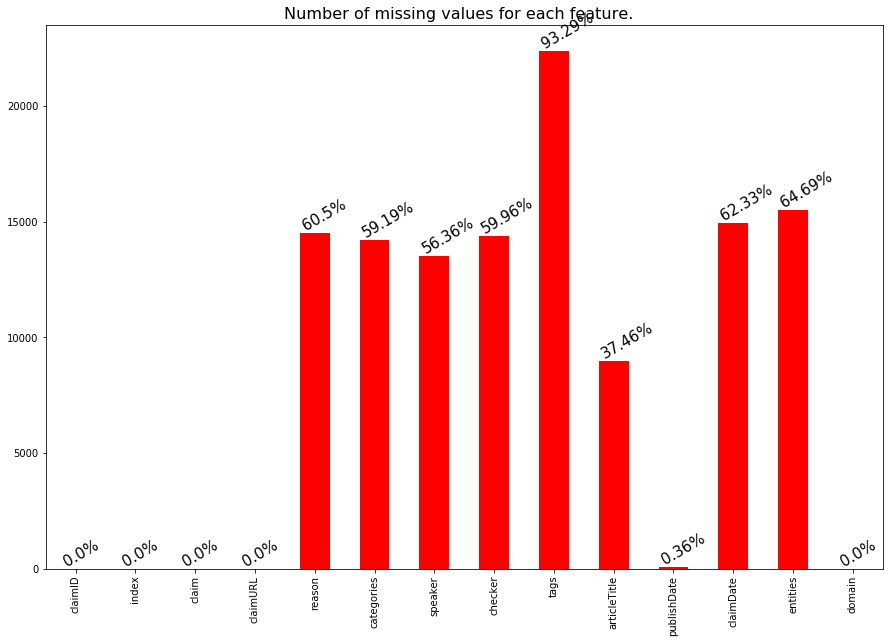

In [19]:
# The code for displaying % in barplot : https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html


df_train.replace(to_replace = 'None',value=np.nan ,inplace = True)
df_train.replace(to_replace = "['None']",value=np.nan ,inplace = True)

axes = df_train.isnull().sum().plot(kind='bar',color='r', stacked=True)
axes.set_title('Number of missing values for each feature.  ', fontsize=16)


all_rec = len(df_train)

for i in axes.patches:
    axes.text(i.get_x(), i.get_height() + 100, \
            str(round((i.get_height()/all_rec)*100, 2))+'%', fontsize=15,rotation=30)


In [29]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [39]:
all_v= []

for idi in test_set.claimID.unique():
    rec = test_set[ test_set['claimID']==idi]
   
    claim_i = rec['claim'].unique()[0]
    liste =  rec['snip_2'].to_list()
    liste.insert(0,claim_i)
    try:
        embeddings = embed(liste)
    except:
           pass
        
    v = np.round(np.inner(embeddings,embeddings),2)[0][1:]
   
    all_v.append(v)

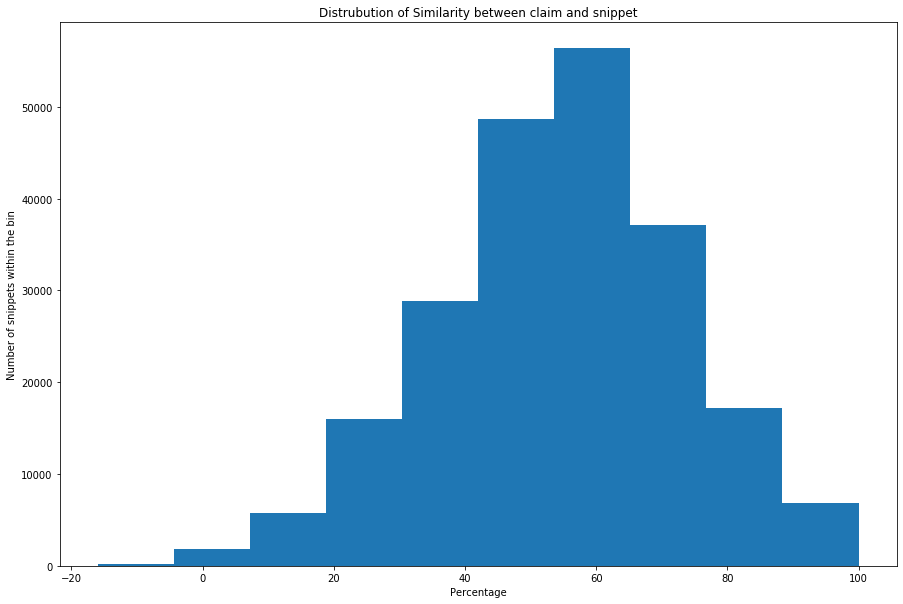

In [51]:
allv = np.hstack(all_v)*100

plt.hist(allv, bins=10)
plt.title('Distrubution of Similarity between claim and snippet')
plt.xlabel('Percentage')
plt.ylabel('Number of snippets within the bin')
plt.show()

In [112]:
result = pd.read_csv("./multifc_results_cop.csv",sep=';' )

In [113]:
result = result.set_index('Domain')
result.drop('Average',inplace=True)
for col in result:
    result[col] = result[col].astype('float64')



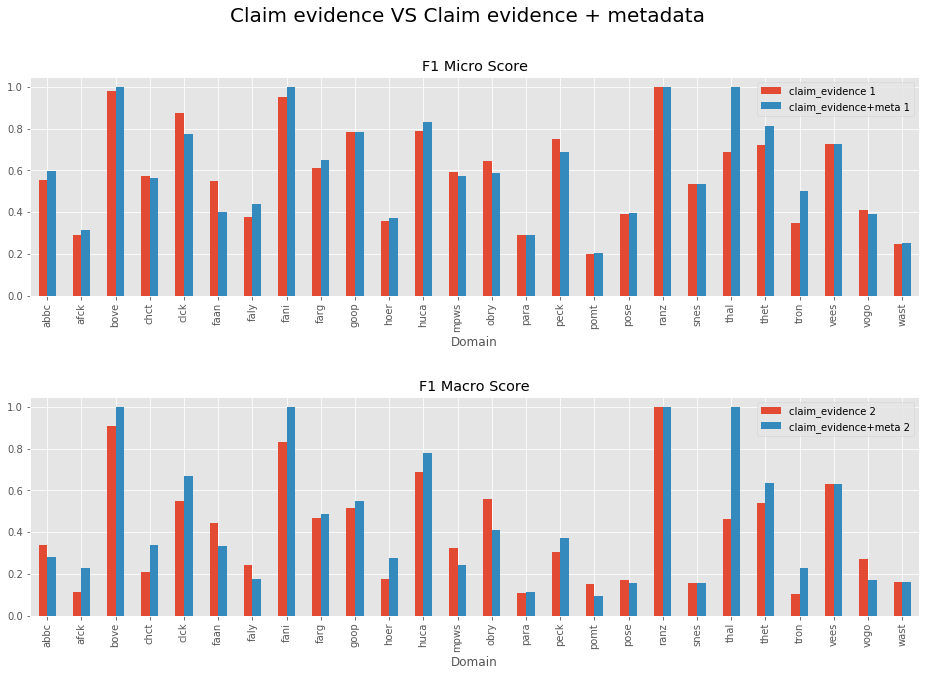

In [114]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.suptitle('Claim evidence VS Claim evidence + metadata', fontsize=20)
fig.tight_layout(pad=8)
axes[0].set_title('F1 Micro Score')
axes[1].set_title('F1 Macro Score')
result[['claim_evidence 1','claim_evidence+meta 1' ]].plot.bar( ax = axes[0])
result[['claim_evidence 2','claim_evidence+meta 2' ]].plot.bar( ax = axes[1])

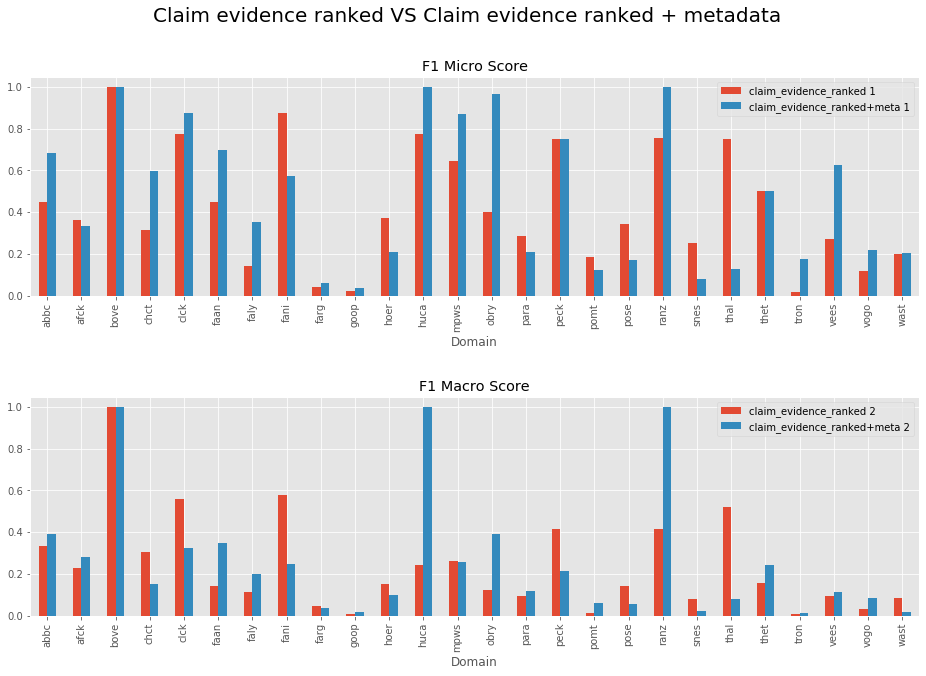

In [115]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.suptitle('Claim evidence ranked VS Claim evidence ranked + metadata', fontsize=20)
fig.tight_layout(pad=8)
axes[0].set_title('F1 Micro Score')
axes[1].set_title('F1 Macro Score')
result[['claim_evidence_ranked 1','claim_evidence_ranked+meta 1' ]].plot.bar( ax = axes[0])
result[['claim_evidence_ranked 2','claim_evidence_ranked+meta 2' ]].plot.bar( ax = axes[1])


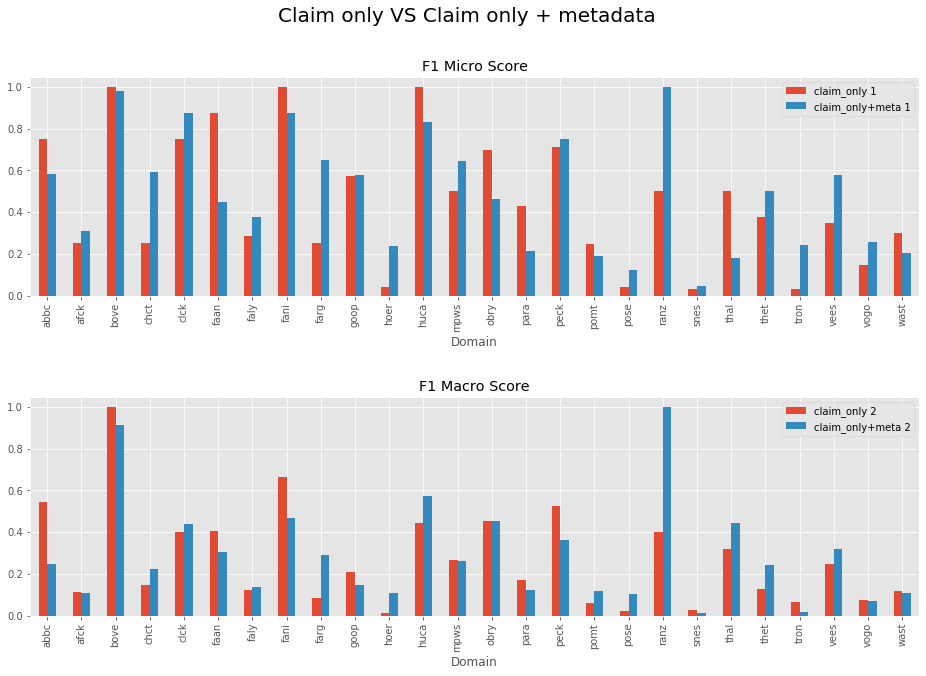

In [116]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.suptitle('Claim only VS Claim only + metadata', fontsize=20)
fig.tight_layout(pad=8)
axes[0].set_title('F1 Micro Score')
axes[1].set_title('F1 Macro Score')
result[['claim_only 1','claim_only+meta 1' ]].plot.bar( ax = axes[0])
result[['claim_only 2','claim_only+meta 2' ]].plot.bar( ax = axes[1])
